In [48]:
import pandas as pd
from pandas import json_normalize
import itertools
import os

import scienceplots
import matplotlib.pyplot as plt

plt.style.use(['science', 'ieee', 'no-latex'])

import sys
sys.path.append('/Users/francescodesantis/Desktop/VS Local folder/forensic-agent')
from run_agent import main

LLM = ['gpt-4o']
max_iterations = [51]
reasoning = ['react_summary', 'complete']
epochs_to_reset = [20, 100]

configurations = [dict(zip(['LLM','max_iterations','reasoning','epochs_to_reset'],v)) for v in itertools.product(LLM,max_iterations,reasoning,epochs_to_reset)]
len(configurations)

# Define a class to simulate argparse.Namespace
class Args:
    def __init__(self, LLM, max_iterations, reasoning, epochs_to_reset):
        self.LLM = LLM
        self.max_iterations = max_iterations
        self.reasoning = reasoning
        self.epochs_to_reset = epochs_to_reset
                

# Define the arguments
for configuration in configurations:
    args = Args(**configuration)
    # Run the main function
    main(args)
    print('Done with configuration:', configuration)

In [49]:
def cve_check(pred, true):
    if pred=='No Answer' or pd.isna(pred):
        return 'NA'
    
    true = 'cve-'+true
    if true.lower() == pred.lower():
        return 'Correct'
    else:
        return 'Wrong'

def service_check(pred, true):
    if pred=='No Answer':
        return 'NA'
    
    for word in true.split():
        if word.lower() in pred.lower():
            return 'Correct'
    return 'Wrong'
    
def success_check(pred, true):

    if pred=='No Answer':
        return 'NA'

    pred = 'True' if str(pred).lower()=='succeeded' else 'False'
    true = 'True' if true else 'False'

    if pred==true:

        return 'Correct'
    else:
        return 'Wrong'

def vulnerable_check(pred, true): 
    true = 'True' if true else 'False'
    if pred=='No Answer':
        return 'NA'
    
    if pred==true:
        return 'Correct'
    else:
        return 'Wrong'


In [50]:
file_path= 'data/tasks/data.json'

# Read and normalize the nested JSON
df = pd.read_json(file_path)

# Flatten the 'address' column into separate columns
df = json_normalize(df.to_dict(orient='records'))
df.columns=['id','cve', 'service', 'success', 'vulnerable', 'evidence']
df

,id,cve,service,success,vulnerable,evidence
0,0,2022-24706,couchdb,True,True,[TBD]
1,1,2021-43798,grafana,True,True,[TBD]
2,2,2021-41773,apache http server,True,True,[TBD]
3,3,2021-42013,apache http server,True,True,[TBD]
4,4,2024-23897,jenkins,True,True,[TBD]
5,5,2023-23752,joomla,True,True,[TBD]
6,6,2021-44228,apache solr,True,True,[TBD]
7,7,2016-5734,phpmyadmin,True,True,[TBD]
8,8,2018-12613,phpmyadmin,True,True,[TBD]
9,9,2022-46169,cacti,True,True,[TBD]


# ReAct reasoning

In [51]:
react_results_seed0 = pd.read_csv('results/react_gpt-4o_False_0.csv', delimiter=';').drop(columns=['Unnamed: 0'])

react_results_seed0['cve_true'] = df['cve']
react_results_seed0['service_true'] = df['service']
react_results_seed0['success_true'] = df['success']
react_results_seed0['vulnerable_true'] = df['vulnerable']

react_results_seed0['cve_check'] = react_results_seed0.apply(lambda x: cve_check(x['cve'], x['cve_true']), axis=1)
react_results_seed0['service_check'] = react_results_seed0.apply(lambda x: service_check(x['service'], x['service_true']), axis=1)
react_results_seed0['success_check'] = react_results_seed0.apply(lambda x: success_check(x['successful'], x['success_true']), axis=1)
react_results_seed0['vulnerable_check'] = react_results_seed0.apply(lambda x: vulnerable_check(x['is_vulnerable'], x['vulnerable_true']), axis=1)
react_results_seed0['method'] = 'React'
react_results_seed0['seed'] = 0

react_results_seed1 = pd.read_csv('results/react_gpt-4o_False_1.csv', delimiter=';').drop(columns=['Unnamed: 0'])

react_results_seed1['cve_true'] = df['cve']
react_results_seed1['service_true'] = df['service']
react_results_seed1['success_true'] = df['success']
react_results_seed1['vulnerable_true'] = df['vulnerable']

react_results_seed1['cve_check'] = react_results_seed1.apply(lambda x: cve_check(x['cve'], x['cve_true']), axis=1)
react_results_seed1['service_check'] = react_results_seed1.apply(lambda x: service_check(x['service'], x['service_true']), axis=1)
react_results_seed1['success_check'] = react_results_seed1.apply(lambda x: success_check(x['successful'], x['success_true']), axis=1)
react_results_seed1['vulnerable_check'] = react_results_seed1.apply(lambda x: vulnerable_check(x['is_vulnerable'], x['vulnerable_true']), axis=1)
react_results_seed1['method'] = 'React'
react_results_seed1['seed'] = 1

react_results = pd.concat([react_results_seed0, react_results_seed1])

In [52]:
react_summary_results_seed1 = pd.read_csv('results/react_summary_gpt-4o_False_1.csv', delimiter=';').drop(columns=['Unnamed: 0']).fillna('No Answer')

react_summary_results_seed1['cve_true'] = df['cve']
react_summary_results_seed1['service_true'] = df['service']
react_summary_results_seed1['success_true'] = df['success']
react_summary_results_seed1['vulnerable_true'] = df['vulnerable']

react_summary_results_seed1['cve_check'] = react_summary_results_seed1.apply(lambda x: cve_check(x['cve'], x['cve_true']), axis=1)
react_summary_results_seed1['service_check'] = react_summary_results_seed1.apply(lambda x: service_check(x['service'], x['service_true']), axis=1)
react_summary_results_seed1['success_check'] = react_summary_results_seed1.apply(lambda x: success_check(x['successful'], x['success_true']), axis=1)
react_summary_results_seed1['vulnerable_check'] = react_summary_results_seed1.apply(lambda x: vulnerable_check(x['is_vulnerable'], x['vulnerable_true']), axis=1)
react_summary_results_seed1['method'] = 'React+Summary'
react_summary_results_seed1['seed'] = 1

react_summary_results_seed0 = pd.read_csv('results/react_summary_gpt-4o_False_0.csv', delimiter=';').drop(columns=['Unnamed: 0']).fillna('No Answer')

react_summary_results_seed0['cve_true'] = df['cve']
react_summary_results_seed0['service_true'] = df['service']
react_summary_results_seed0['success_true'] = df['success']
react_summary_results_seed0['vulnerable_true'] = df['vulnerable']

react_summary_results_seed0['cve_check'] = react_summary_results_seed0.apply(lambda x: cve_check(x['cve'], x['cve_true']), axis=1)
react_summary_results_seed0['service_check'] = react_summary_results_seed0.apply(lambda x: service_check(x['service'], x['service_true']), axis=1)
react_summary_results_seed0['success_check'] = react_summary_results_seed0.apply(lambda x: success_check(x['successful'], x['success_true']), axis=1)
react_summary_results_seed0['vulnerable_check'] = react_summary_results_seed0.apply(lambda x: vulnerable_check(x['is_vulnerable'], x['vulnerable_true']), axis=1)
react_summary_results_seed0['method'] = 'React+Summary'
react_summary_results_seed0['seed'] = 0

react_summary_results = pd.concat([react_summary_results_seed0, react_summary_results_seed1])

In [53]:
complete_seed0 = pd.read_csv('results/complete_gpt-4o_False_0.csv', delimiter=';').drop(columns=['Unnamed: 0']).fillna('No Answer')

complete_seed0['cve_true'] = df['cve']
complete_seed0['service_true'] = df['service']
complete_seed0['success_true'] = df['success']
complete_seed0['vulnerable_true'] = df['vulnerable']

complete_seed0['cve_check'] = complete_seed0.apply(lambda x: cve_check(x['cve'], x['cve_true']), axis=1)
complete_seed0['service_check'] = complete_seed0.apply(lambda x: service_check(x['service'], x['service_true']), axis=1)
complete_seed0['success_check'] = complete_seed0.apply(lambda x: success_check(x['successful'], x['success_true']), axis=1)
complete_seed0['vulnerable_check'] = complete_seed0.apply(lambda x: vulnerable_check(x['is_vulnerable'], x['vulnerable_true']), axis=1)
complete_seed0['method'] = 'Decoupled'
complete_seed0['seed'] = 0

complete_seed1 = pd.read_csv('results/complete_gpt-4o_False_1.csv', delimiter=';').drop(columns=['Unnamed: 0']).fillna('No Answer')

complete_seed1['cve_true'] = df['cve']
complete_seed1['service_true'] = df['service']
complete_seed1['success_true'] = df['success']
complete_seed1['vulnerable_true'] = df['vulnerable']

complete_seed1['cve_check'] = complete_seed1.apply(lambda x: cve_check(x['cve'], x['cve_true']), axis=1)
complete_seed1['service_check'] = complete_seed1.apply(lambda x: service_check(x['service'], x['service_true']), axis=1)
complete_seed1['success_check'] = complete_seed1.apply(lambda x: success_check(x['successful'], x['success_true']), axis=1)
complete_seed1['vulnerable_check'] = complete_seed1.apply(lambda x: vulnerable_check(x['is_vulnerable'], x['vulnerable_true']), axis=1)
complete_seed1['method'] = 'Decoupled'
complete_seed1['seed'] = 1

complete = pd.concat([complete_seed0, complete_seed1])
complete


,id,cve,service,successful,is_vulnerable,n_iterations,error,evidence,cve_true,service_true,success_true,vulnerable_true,cve_check,service_check,success_check,vulnerable_check,method,seed
0,0,No Answer,"epmd, pdl_datastream",Failed,False,24,False,Evidence not required,2022-24706,couchdb,True,True,NA,Wrong,Wrong,Wrong,Decoupled,0
1,1,CVE-2001-0583,MDaemon WorldClient,Failed,True,50,False,Evidence not required,2021-43798,grafana,True,True,Wrong,Wrong,Wrong,Correct,Decoupled,0
2,2,"CVE-2021-41773, CVE-2021-42013",Apache/2.4.49 (Unix),Succeeded,True,7,False,Evidence not required,2021-41773,apache http server,True,True,Wrong,Correct,Correct,Correct,Decoupled,0
3,3,CVE-2021-41773,Apache/2.4.50 (Unix),Failed,False,50,False,Evidence not required,2021-42013,apache http server,True,True,Wrong,Correct,Wrong,Wrong,Decoupled,0
4,4,No Answer,No Answer,No Answer,No Answer,48,"Error code: 400 - {'error': {'message': ""This ...",Evidence not required,2024-23897,jenkins,True,True,NA,NA,NA,NA,Decoupled,0
5,5,"CVE-2023-22084, CVE-2023-22028",MySQL Server 5.7.44,Failed,False,50,False,Evidence not required,2023-23752,joomla,True,True,Wrong,Wrong,Wrong,Wrong,Decoupled,0
6,6,No Answer,No Answer,No Answer,No Answer,5,7 validation errors for ActionModel\naction.Ex...,Evidence not required,2021-44228,apache solr,True,True,NA,NA,NA,NA,Decoupled,0
7,7,No Answer,HTTP,Failed,False,50,False,Evidence not required,2016-5734,phpmyadmin,True,True,NA,Wrong,Wrong,Wrong,Decoupled,0
8,8,CVE-2016-4975,Apache/2.4.25 with PHP/7.2.5,Failed,False,50,False,Evidence not required,2018-12613,phpmyadmin,True,True,Wrong,Wrong,Wrong,Wrong,Decoupled,0
9,9,No Answer,No Answer,No Answer,No Answer,1,"Error code: 400 - {'error': {'message': ""This ...",Evidence not required,2022-46169,cacti,True,True,NA,NA,NA,NA,Decoupled,0


In [54]:
res = [react_results, react_summary_results, complete]
res = pd.concat(res)

method_order = ['React', 'React+Summary', 'Decoupled']
res['method'] = pd.Categorical(res['method'], categories=method_order, ordered=True)
res = res.sort_values('method')

res

,id,cve,service,successful,is_vulnerable,n_iterations,error,evidence,cve_true,service_true,success_true,vulnerable_true,cve_check,service_check,success_check,vulnerable_check,method,seed
0,0,NaN,Printing service on port 9100,Failed,True,6,False,Evidence not required,2022-24706,couchdb,True,True,NA,Wrong,Wrong,Correct,React,0
2,2,"CVE-2017-16105, CVE-2018-10176, CVE-2021-34820",HTTP server,Failed,True,4,False,Evidence not required,2021-41773,apache http server,True,True,Wrong,Correct,Wrong,Correct,React,1
3,3,CVE-2023-34062,Reactor Netty HTTP Server,Failed,False,6,False,Evidence not required,2021-42013,apache http server,True,True,Wrong,Correct,Wrong,Wrong,React,1
4,4,No Answer,No Answer,No Answer,No Answer,9,7 validation errors for ReActModel\naction.Ext...,Evidence not required,2024-23897,jenkins,True,True,NA,NA,NA,NA,React,1
5,5,"CVE-2023-22084, CVE-2023-22028",MySQL 5.7.44,Failed,False,34,False,Evidence not required,2023-23752,joomla,True,True,Wrong,Wrong,Wrong,Wrong,React,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14,14,"CVE-2021-28235, CVE-2022-34038, CVE-2020-15113",etcd,Failed,True,50,False,Evidence not required,2021-45232,apisix,False,True,Wrong,Wrong,Correct,Correct,Decoupled,0
15,15,No Answer,No Answer,No Answer,No Answer,2,7 validation errors for ActionModel\naction.Ex...,Evidence not required,2021-45232,apisix,True,True,NA,NA,NA,NA,Decoupled,0
16,16,No Answer,ActiveMQ 5.17.3,Failed,False,14,False,Evidence not required,2017-15709,activemq,False,False,NA,Correct,Correct,Correct,Decoupled,0
18,18,No Answer,No Answer,No Answer,No Answer,1,"Error code: 400 - {'error': {'message': ""This ...",Evidence not required,2021-22205,gitlab,False,False,NA,NA,NA,NA,Decoupled,0


In [55]:
average_iterations = res.groupby('method')['n_iterations'].mean()
average_iterations

/var/folders/k2/8dbxh7xn12z05nbd26hkb9j40000gn/T/ipykernel_10535/2966652616.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  average_iterations = res.groupby('method')['n_iterations'].mean()


method
React            14.400
React+Summary    23.525
Decoupled        17.350
Name: n_iterations, dtype: float64

In [56]:
columns_to_explore = ['service_check', 'cve_check', 'vulnerable_check', 'success_check', 'n_iterations']

cols = ['service', 'cve', 'vulnerable', 'success', 'n_iterations']
df  = pd.DataFrame(columns = cols)

for i, column in enumerate(columns_to_explore):   
    if column=='n_iterations':
        data_true = res.groupby('method')['n_iterations'].mean()
    else:
        data_true = res.groupby(['method', column]).size().unstack().fillna(0)
        data_true = data_true.div(data_true.sum(axis=1), axis=0)['Correct']
    df[cols[i]] = data_true

df.T

/var/folders/k2/8dbxh7xn12z05nbd26hkb9j40000gn/T/ipykernel_10535/1470527131.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data_true = res.groupby(['method', column]).size().unstack().fillna(0)
/var/folders/k2/8dbxh7xn12z05nbd26hkb9j40000gn/T/ipykernel_10535/1470527131.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data_true = res.groupby(['method', column]).size().unstack().fillna(0)
/var/folders/k2/8dbxh7xn12z05nbd26hkb9j40000gn/T/ipykernel_10535/1470527131.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=F

method,React,React+Summary,Decoupled
service,0.425,0.375,0.225
cve,0.075,0.075,0.000
vulnerable,0.500,0.400,0.250
success,0.200,0.225,0.125
n_iterations,14.400,23.525,17.350


/var/folders/k2/8dbxh7xn12z05nbd26hkb9j40000gn/T/ipykernel_7019/2282061712.py:33: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data_true = res.groupby(['method', column]).size().unstack().fillna(0)
/var/folders/k2/8dbxh7xn12z05nbd26hkb9j40000gn/T/ipykernel_7019/2282061712.py:42: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_iterations = res.groupby(['method', column])['n_iterations'].mean().unstack().fillna(0)
/var/folders/k2/8dbxh7xn12z05nbd26hkb9j40000gn/T/ipykernel_7019/2282061712.py:33: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of panda

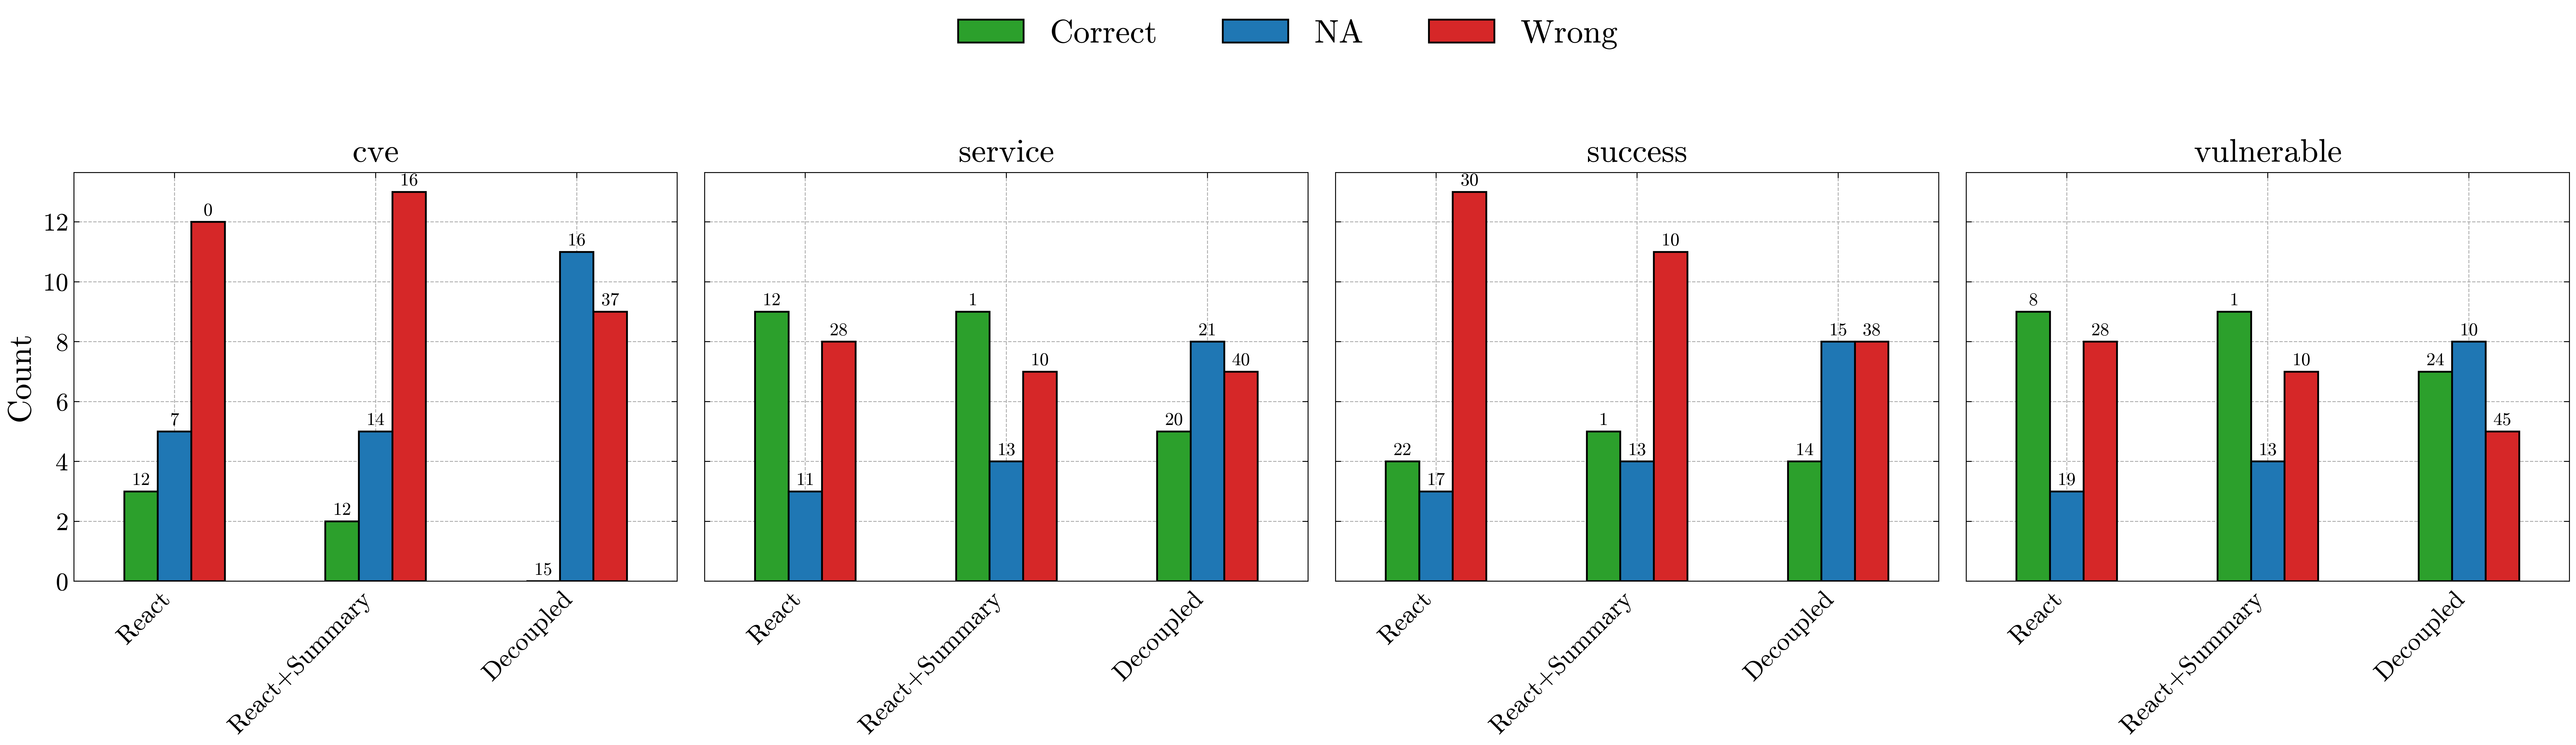

In [7]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import warnings

# Set global font properties
plt.rcParams.update({
    'font.size': 14,
    'axes.titlesize': 18,
    'axes.labelsize': 18,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'legend.fontsize': 18
})

res = [react_results, react_summary_results, complete]
res = pd.concat(res)

method_order = ['React', 'React+Summary', 'Decoupled']
res['method'] = pd.Categorical(res['method'], categories=method_order, ordered=True)
res = res.sort_values('method')

# Define the custom color map
color_map = {'Correct': 'tab:green', 'NA': 'tab:blue', 'Wrong': 'tab:red'}

columns_to_explore = ['cve_check', 'service_check', 'success_check', 'vulnerable_check']
methods = res['method'].unique()

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 5), sharey=True)

# Create a unique legend
handles, labels = [], []
for column in columns_to_explore:
    data_true = res.groupby(['method', column]).size().unstack().fillna(0)
    handle, label = data_true.plot(kind='bar', ax=axes[columns_to_explore.index(column)], color=[color_map.get(x, 'black') for x in data_true.columns], edgecolor='black', zorder=3).get_legend_handles_labels()
    handles.extend(handle)
    labels.extend(label)
    axes[columns_to_explore.index(column)].get_legend().remove()
    axes[columns_to_explore.index(column)].grid(True, which='major', linestyle='--', linewidth=0.5, zorder=0)
    axes[columns_to_explore.index(column)].minorticks_off()

    # Calculate and annotate the average number of iterations
    avg_iterations = res.groupby(['method', column])['n_iterations'].mean().unstack().fillna(0)
    for i, method in enumerate(method_order):
        for j, status in enumerate(avg_iterations.columns):
            value = avg_iterations.loc[method, status]
            bar = axes[columns_to_explore.index(column)].patches[i * len(avg_iterations.columns) + j]
            axes[columns_to_explore.index(column)].text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.1, f'{int(round(value))}', ha='center', va='bottom', fontsize=10, color='black')

# Add the unique legend below the figure
fig.legend(handles[:3], labels[:3], loc='lower center', ncol=3, bbox_to_anchor=(0.5, 1.05))
axes = axes.flatten()

for ax, column in zip(axes, columns_to_explore):
    ax.set_title(f'{column}'.replace('_check',''))
    ax.set_xlabel('')
    ax.set_ylabel('Count')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.subplots_adjust(hspace=1.4)  # Adjust the space between the two lines of figures
plt.savefig('figs/evaluation.pdf')
plt.show()


In [8]:
import pandas as pd

# Assuming react_results, react_summary_results, and complete are already defined DataFrames
res = [react_results, react_summary_results, complete]
res = pd.concat(res)

method_order = ['React', 'React+Summary', 'Decoupled']
res['method'] = pd.Categorical(res['method'], categories=method_order, ordered=True)
res = res.sort_values('method')

columns_to_explore = ['cve_check', 'service_check', 'success_check', 'vulnerable_check']

# Create a summary table
summary_table = pd.DataFrame()

for column in columns_to_explore:
    data_true = res.groupby(['method', column]).size().unstack().fillna(0)
    avg_iterations = res.groupby(['method', column])['n_iterations'].mean().unstack().fillna(0)
    combined = data_true.astype(str) + ' (' + avg_iterations.round(1).astype(str) + ')'
    combined.columns = [f'{column}_{col}' for col in combined.columns]
    summary_table = pd.concat([summary_table, combined], axis=1)

# Create a separate column for the number of iterations
iterations_table = avg_iterations.add_suffix('_iterations')
summary_table = pd.concat([summary_table, iterations_table], axis=1)

# Display the summary table
summary_table[[x for x in summary_table.columns if 'iterations' in x.lower()]]


/var/folders/k2/8dbxh7xn12z05nbd26hkb9j40000gn/T/ipykernel_7019/1720365025.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data_true = res.groupby(['method', column]).size().unstack().fillna(0)
/var/folders/k2/8dbxh7xn12z05nbd26hkb9j40000gn/T/ipykernel_7019/1720365025.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_iterations = res.groupby(['method', column])['n_iterations'].mean().unstack().fillna(0)
/var/folders/k2/8dbxh7xn12z05nbd26hkb9j40000gn/T/ipykernel_7019/1720365025.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of panda

,Correct_iterations,NA_iterations,Wrong_iterations
method,,,
React,8.111111,1.00,24.500000
React+Summary,19.222222,12.75,10.285714
Decoupled,28.142857,10.50,44.800000


In [54]:
%pip install --upgrade tiktoken -q


Note: you may need to restart the kernel to use updated packages.


In [19]:
import tiktoken

for i in ['react', 'react_summary', 'complete']:
    # compute average number of produced tokens
    path = f'log/{i}_gpt-4o_False_0'
    files = os.listdir(path)
    files = [file for file in files if file.endswith('.json')]

    # To get the tokeniser corresponding to a specific model in the OpenAI API:
    encoding = tiktoken.encoding_for_model('gpt-4o')

    contents = []
    for file in files:
        with open(os.path.join(path, file), 'r') as f:
            contents.append(f.read())


    # Initialize the tokenizer
    enc = tiktoken.encoding_for_model("gpt-4o")

    # Compute the number of tokens in each content
    tokens = []#[len(enc.encode(content)) for content in contents]
    for content in contents:
        #if 'context_length_exceeded' in content:
        #    tokens.append(120000)
        #else:
        tokens.append(len(enc.encode(content)))
    print(f'Average number of tokens for {i}: {sum(tokens)/len(tokens)}')

Average number of tokens for react: 26327.7
Average number of tokens for react_summary: 54828.35
Average number of tokens for complete: 47707.05


In [58]:
contents[0]

'{"steps": [{"thought": "Thought: ", "action": "Action: str()", "observation": "Observation: \\nAnalyze the provided PCAP (Packet Capture) file to accomplish the following tasks:\\n\\n1. Analyze the PCAP in order to have an understanding of the network traffic.\\n2. Identify the services and applications involved in the network traffic.\\n3. Determine the relevant CVEs (Common Vulnerabilities and Exposures).\\n4. Assess whether the services or applications are vulnerable to the identified attacks.\\n5. Evaluate whether the attacks were successful.\\n\\nHINTS:\\n- Use the tools provided to extract and expand the data from the PCAP file.\\n- Utilize the online search tool to verify the findings and gather additional information.\\n\\nThe current PCAP file has 12 packets (frames)\\nFrame 1: Ether / ARP who has 172.18.0.2 says 172.18.0.1\\nFrame 2: Ether / ARP is at 02:42:ac:12:00:02 says 172.18.0.2\\nFrame 3: Ether / IP / TCP 172.18.0.1:41374 > 172.18.0.2:61616 S\\nFrame 4: Ether / IP / T

In [47]:
import tiktoken

for i in ['react', 'react_summary', 'complete']:
    # compute average number of produced tokens
    files = []
    path = f'log/{i}_gpt-4o_False_0'
    files_ = os.listdir(path)
    files += [os.path.join(path,file) for file in files_ if file.endswith('.json')]

    path = f'log/{i}_gpt-4o_False_1'
    files_ = os.listdir(path)
    files += [os.path.join(path,file) for file in files_ if file.endswith('.json')]

    # To get the tokeniser corresponding to a specific model in the OpenAI API:
    encoding = tiktoken.encoding_for_model('gpt-4o')

    contents = []
    for file in files:
        with open(file, 'r') as f:
            contents.append(f.read())

    # Initialize the tokenizer
    enc = tiktoken.encoding_for_model("gpt-4o")

    # Compute the number of tokens in each content
    fails = 0#[len(enc.encode(content)) for content in contents]
    for content in contents:
        if 'context_length_exceeded' in content:
            fails+=1
    fails/=2
    print(f'Number of fails for {i}: {fails}')

Number of fails for react: 1.5
Number of fails for react_summary: 4.5
Number of fails for complete: 3.5


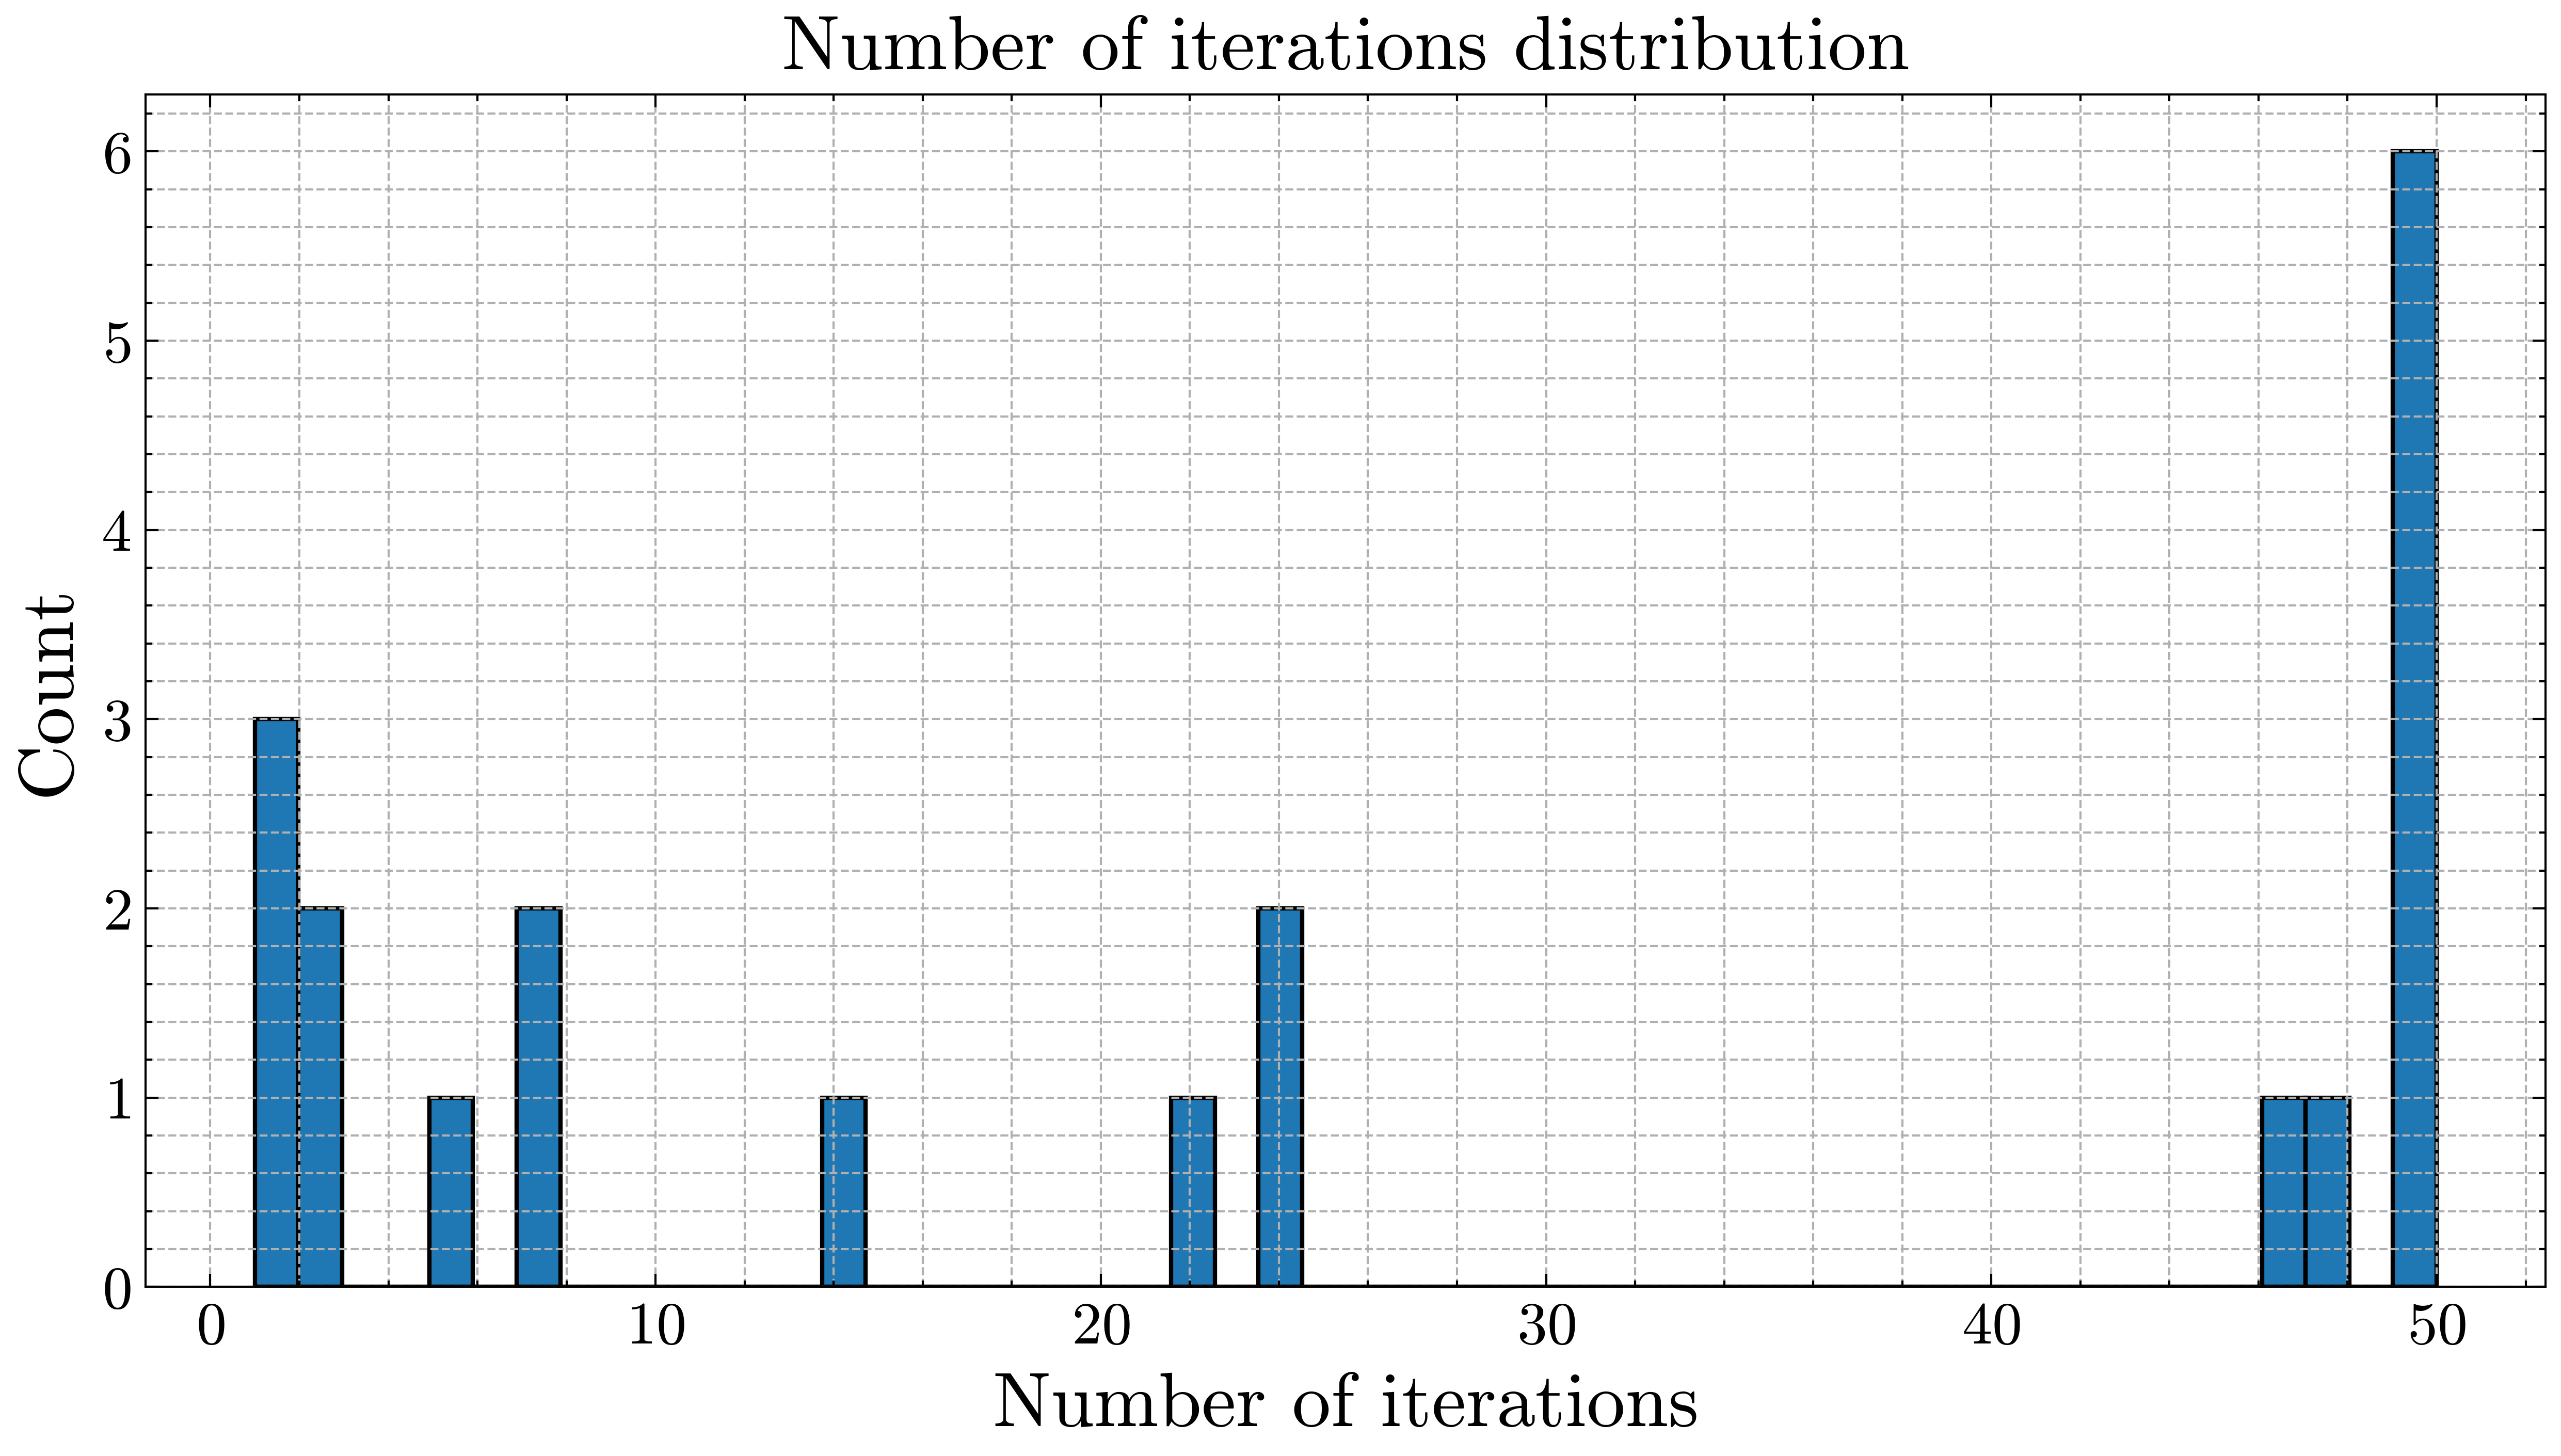

In [34]:
# plot the distribution of the number of iterations
plt.figure(figsize=(10, 5))
plt.hist(complete['n_iterations'], bins=50, color='tab:blue', edgecolor='black')
plt.title('Number of iterations distribution', fontsize=18)
plt.xlabel('Number of iterations', fontsize=18)
plt.ylabel('Count', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

# 

# ReAct+Summary reasoning

In [5]:
react_summary_results = pd.read_csv('results_no_logs/react_summary_agent_noReset_results.csv',delimiter=';').drop(columns=['Unnamed: 0'])
react_summary_results['reset'] = 'False'

react_summary_reset_results = pd.read_csv('results_no_logs/react_summary_agent_Reset_results.csv',delimiter=';').drop(columns=['Unnamed: 0'])
react_summary_reset_results['reset'] = 'True'

react_summary_results = pd.concat([react_summary_results, react_summary_reset_results])

react_summary_results['cve_true'] = df['cve']
react_summary_results['service_true'] = df['service']
react_summary_results['success_true'] = df['success']
react_summary_results['vulnerable_true'] = df['vulnerable']

react_summary_results['cve_check'] = react_summary_results.apply(lambda x: cve_check(x['cve'], x['cve_true']), axis=1)
react_summary_results['service_check'] = react_summary_results.apply(lambda x: service_check(x['service'], x['service_true']), axis=1)
react_summary_results['success_check'] = react_summary_results.apply(lambda x: success_check(x['successful'], x['success_true']), axis=1)
react_summary_results['vulnerable_check'] = react_summary_results.apply(lambda x: vulnerable_check(x['is_vulnerable'], x['vulnerable_true']), axis=1)
react_summary_results['method'] = 'React+Summary Agent'

# ReAct+Summary+Decoupling reasoning

In [6]:
complete_results = pd.read_csv('results_no_logs/complete_agent_noReset_results.csv', delimiter=';').drop(columns=['Unnamed: 0'])
complete_results['reset'] = 'False'

complete_reset_results = pd.read_csv('results_no_logs/complete_agent_Reset_results.csv', delimiter=';').drop(columns=['Unnamed: 0'])
complete_reset_results['reset'] = 'True'

complete_results = pd.concat([complete_results, complete_reset_results])

complete_results['cve_true'] = df['cve']
complete_results['service_true'] = df['service']
complete_results['success_true'] = df['success']
complete_results['vulnerable_true'] = df['vulnerable']

complete_results['cve_check'] = complete_results.apply(lambda x: cve_check(x['cve'], x['cve_true']), axis=1)
complete_results['service_check'] = complete_results.apply(lambda x: service_check(x['service'], x['service_true']), axis=1)
complete_results['success_check'] = complete_results.apply(lambda x: success_check(x['successful'], x['success_true']), axis=1)
complete_results['vulnerable_check'] = complete_results.apply(lambda x: vulnerable_check(x['is_vulnerable'], x['vulnerable_true']), axis=1)
complete_results['method'] = 'Complete Agent'

# Results

In [7]:
res = [react_results, react_summary_results, complete_results]
res = pd.concat(res)

method_order = ['React Agent', 'React+Summary Agent', 'Complete Agent']
res['method'] = pd.Categorical(res['method'], categories=method_order, ordered=True)
res = res.sort_values('method')


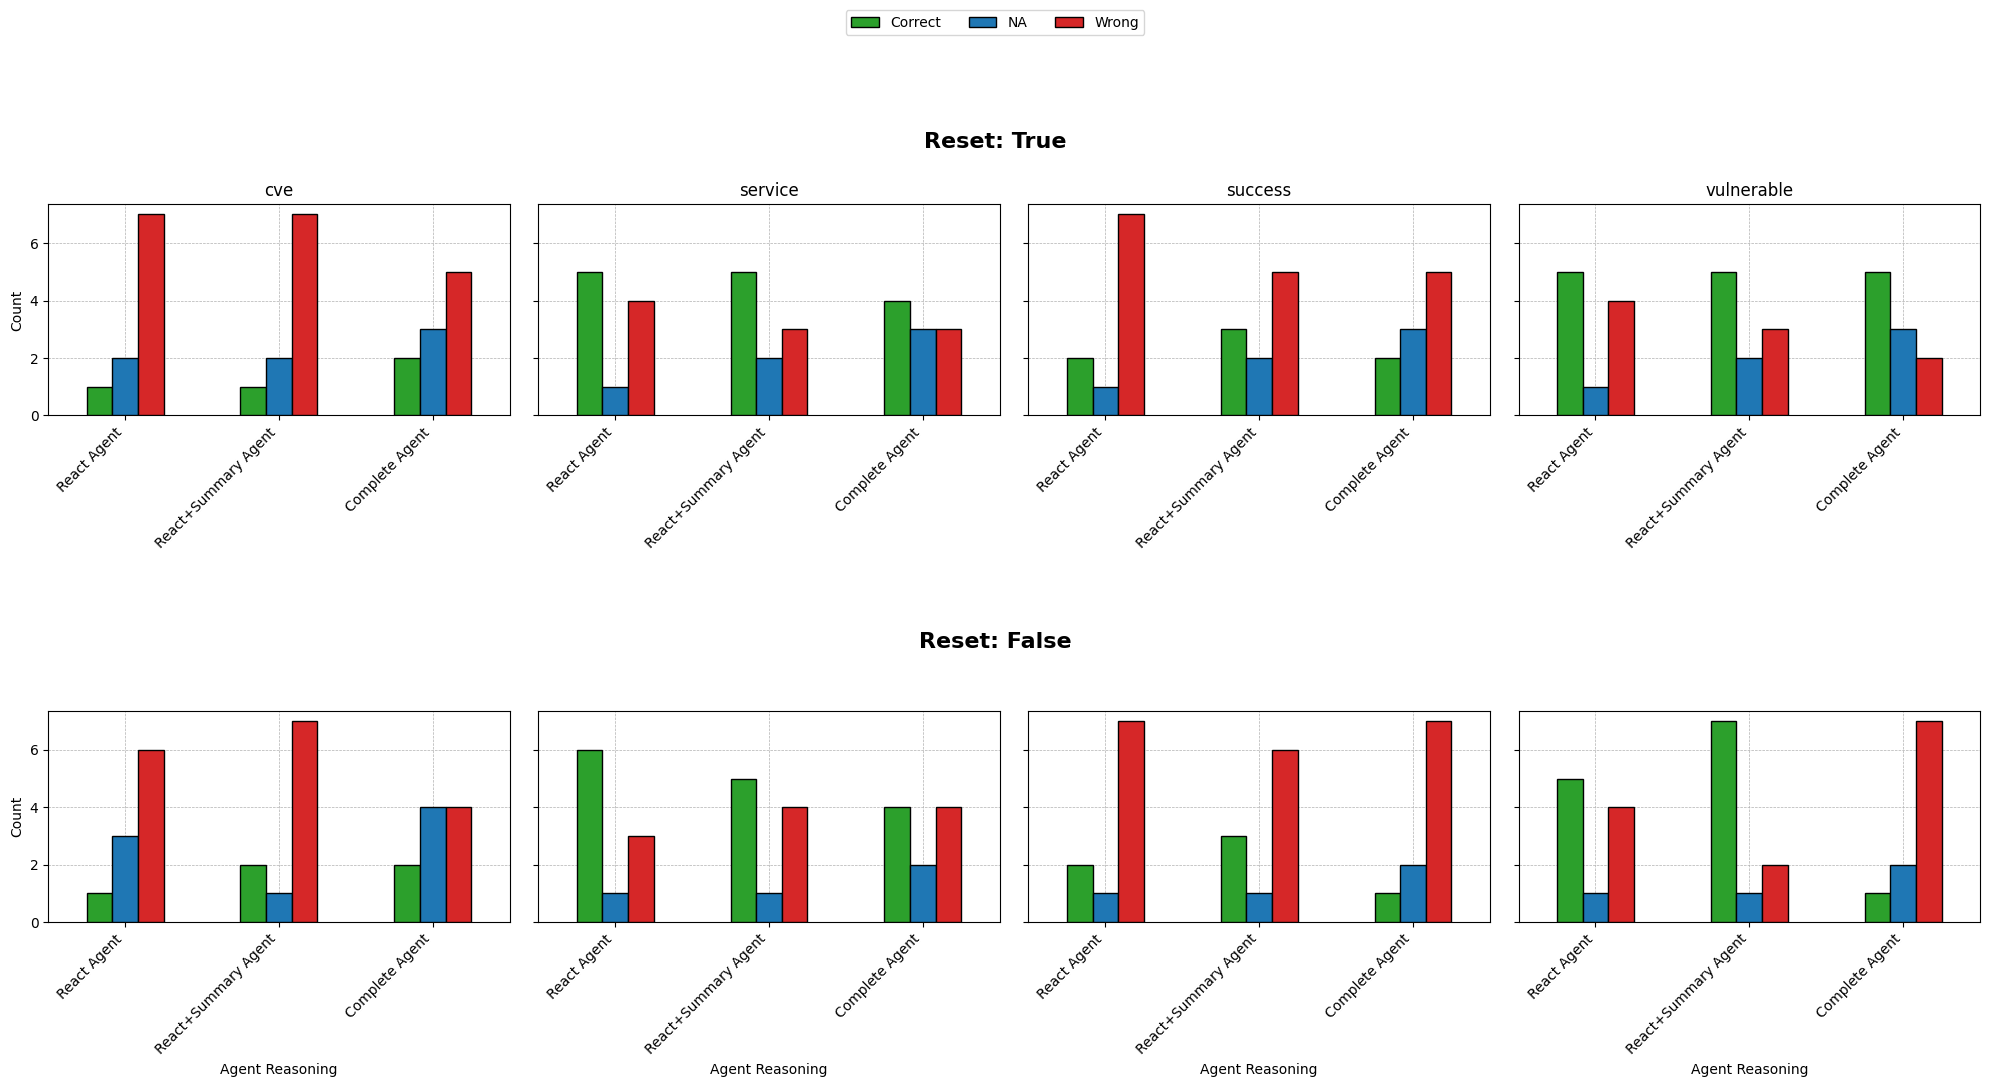

In [8]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import warnings

warnings.filterwarnings('ignore')

# Define the custom color map
color_map = {'Correct': 'tab:green', 'NA': 'tab:blue', 'Wrong': 'tab:red'}

columns_to_explore = ['cve_check', 'service_check', 'success_check', 'vulnerable_check']
methods = res['method'].unique()

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 10), sharey=True)

# Filter the data
res_true = res[res['reset'] == 'True']
res_false = res[res['reset'] == 'False']

# Create a unique legend
handles, labels = [], []
for column in columns_to_explore:
    data_true = res_true.groupby(['method', column]).size().unstack().fillna(0)
    handle, label = data_true.plot(kind='bar', ax=axes[0, columns_to_explore.index(column)], color=[color_map.get(x, 'black') for x in data_true.columns], edgecolor='black', zorder=3).get_legend_handles_labels()
    handles.extend(handle)
    labels.extend(label)
    axes[0, columns_to_explore.index(column)].get_legend().remove()
    axes[0, columns_to_explore.index(column)].grid(True, which='both', linestyle='--', linewidth=0.5, zorder=0)

    data_false = res_false.groupby(['method', column]).size().unstack().fillna(0)
    data_false.plot(kind='bar', ax=axes[1, columns_to_explore.index(column)], legend=False, color=[color_map.get(x, 'black') for x in data_false.columns], edgecolor='black', zorder=3)
    axes[1, columns_to_explore.index(column)].grid(True, which='both', linestyle='--', linewidth=0.5, zorder=0)

# Add the unique legend below the figure
fig.legend(handles[:3], labels[:3], loc='lower center', ncol=3, bbox_to_anchor=(0.5, 1.05))
axes = axes.flatten()

for ax, column in zip(axes, columns_to_explore * 2):
    ax.set_title(f'{column}'.replace('_check',''))
    if ax in axes[4:]:
        ax.set_xlabel('Agent Reasoning')        
        ax.set_title('')
    else:
        ax.set_xlabel('')

    ax.set_ylabel('Count')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

# Add suptitles for each line
fig.suptitle('Reset: True', x=0.5, y=0.95, ha='center', va='center', fontsize=16, weight='bold')
fig.text(0.5, 0.45, 'Reset: False', ha='center', va='center', fontsize=16, weight='bold')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.subplots_adjust(hspace=1.4)  # Adjust the space between the two lines of figures
plt.show()



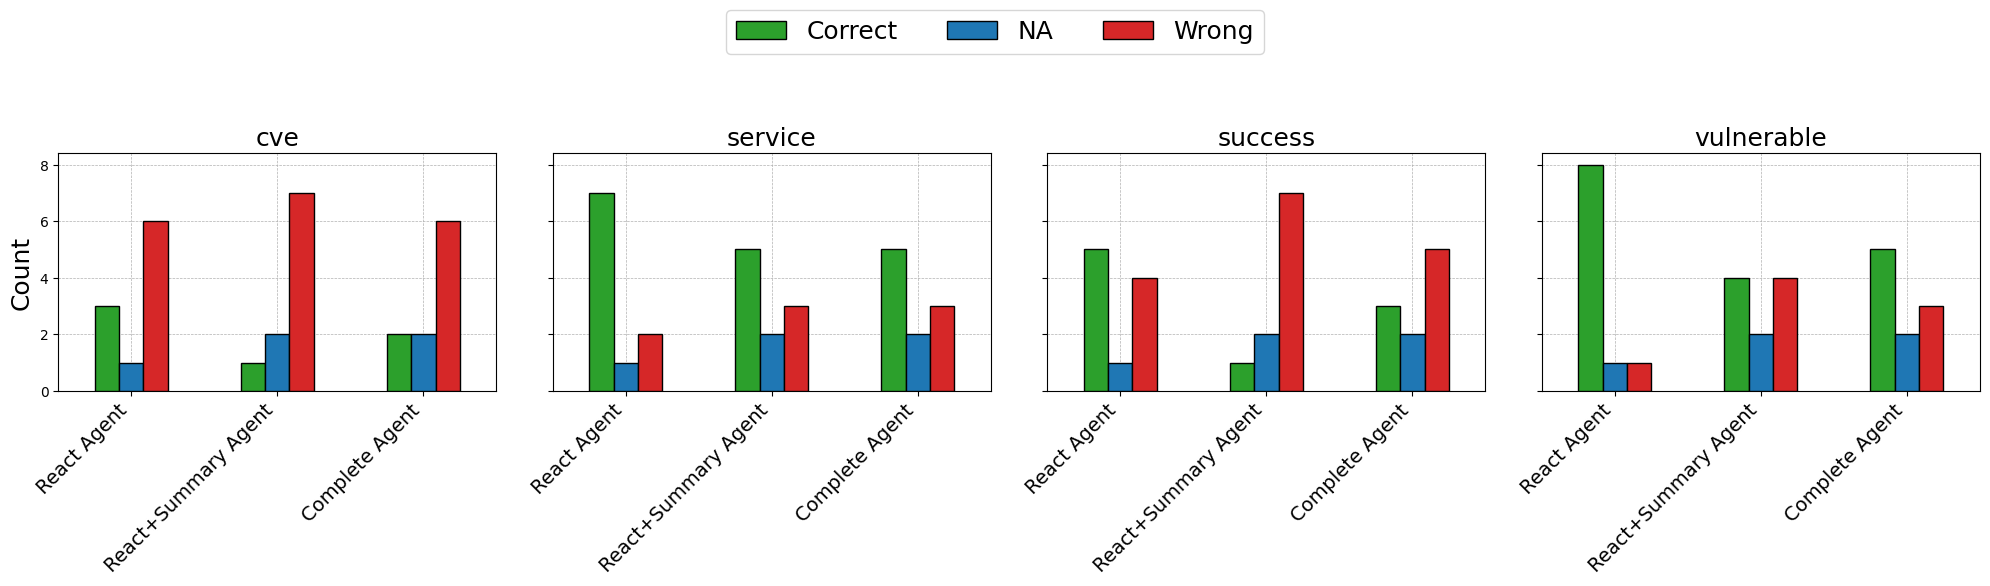

In [20]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import warnings

react_results = pd.read_csv('results/react_agent_noReset_results.csv', delimiter=';').drop(columns=['Unnamed: 0'])
react_results['reset'] = 'False'

react_results['cve_true'] = df['cve']
react_results['service_true'] = df['service']
react_results['success_true'] = df['success']
react_results['vulnerable_true'] = df['vulnerable']

react_results['cve_check'] = react_results.apply(lambda x: cve_check(x['cve'], x['cve_true']), axis=1)
react_results['service_check'] = react_results.apply(lambda x: service_check(x['service'], x['service_true']), axis=1)
react_results['success_check'] = react_results.apply(lambda x: success_check(x['successful'], x['success_true']), axis=1)
react_results['vulnerable_check'] = react_results.apply(lambda x: vulnerable_check(x['is_vulnerable'], x['vulnerable_true']), axis=1)
react_results['method'] = 'React Agent'

react_summary_results = pd.read_csv('results/react_summary_agent_noReset_results.csv',delimiter=';').drop(columns=['Unnamed: 0'])
react_summary_results['reset'] = 'False'

react_summary_results['cve_true'] = df['cve']
react_summary_results['service_true'] = df['service']
react_summary_results['success_true'] = df['success']
react_summary_results['vulnerable_true'] = df['vulnerable']

react_summary_results['cve_check'] = react_summary_results.apply(lambda x: cve_check(x['cve'], x['cve_true']), axis=1)
react_summary_results['service_check'] = react_summary_results.apply(lambda x: service_check(x['service'], x['service_true']), axis=1)
react_summary_results['success_check'] = react_summary_results.apply(lambda x: success_check(x['successful'], x['success_true']), axis=1)
react_summary_results['vulnerable_check'] = react_summary_results.apply(lambda x: vulnerable_check(x['is_vulnerable'], x['vulnerable_true']), axis=1)
react_summary_results['method'] = 'React+Summary Agent'

complete_results = pd.read_csv('results/complete_agent_noReset_results.csv', delimiter=';').drop(columns=['Unnamed: 0'])
complete_results['reset'] = 'False'

complete_results['cve_true'] = df['cve']
complete_results['service_true'] = df['service']
complete_results['success_true'] = df['success']
complete_results['vulnerable_true'] = df['vulnerable']

complete_results['cve_check'] = complete_results.apply(lambda x: cve_check(x['cve'], x['cve_true']), axis=1)
complete_results['service_check'] = complete_results.apply(lambda x: service_check(x['service'], x['service_true']), axis=1)
complete_results['success_check'] = complete_results.apply(lambda x: success_check(x['successful'], x['success_true']), axis=1)
complete_results['vulnerable_check'] = complete_results.apply(lambda x: vulnerable_check(x['is_vulnerable'], x['vulnerable_true']), axis=1)
complete_results['method'] = 'Complete Agent'

res = [react_results, react_summary_results, complete_results]
res = pd.concat(res)

method_order = ['React Agent', 'React+Summary Agent', 'Complete Agent']
res['method'] = pd.Categorical(res['method'], categories=method_order, ordered=True)
res = res.sort_values('method')

# Define the custom color map
color_map = {'Correct': 'tab:green', 'NA': 'tab:blue', 'Wrong': 'tab:red'}

columns_to_explore = ['cve_check', 'service_check', 'success_check', 'vulnerable_check']
methods = res['method'].unique()

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 5), sharey=True)

# Create a unique legend
handles, labels = [], []
for column in columns_to_explore:
    data_true = res.groupby(['method', column]).size().unstack().fillna(0)
    handle, label = data_true.plot(kind='bar', ax=axes[columns_to_explore.index(column)], color=[color_map.get(x, 'black') for x in data_true.columns], edgecolor='black', zorder=3).get_legend_handles_labels()
    handles.extend(handle)
    labels.extend(label)
    axes[columns_to_explore.index(column)].get_legend().remove()
    axes[columns_to_explore.index(column)].grid(True, which='both', linestyle='--', linewidth=0.5, zorder=0)

# Add the unique legend below the figure
fig.legend(handles[:3], labels[:3], loc='lower center', ncol=3, bbox_to_anchor=(0.5, 1.05), fontsize=18)
axes = axes.flatten()

for ax, column in zip(axes, columns_to_explore):
    ax.set_title(f'{column}'.replace('_check',''), fontsize=18)
    ax.set_xlabel('', fontsize=18)
    ax.set_ylabel('Count', fontsize=18)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=14)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.subplots_adjust(hspace=1.4)  # Adjust the space between the two lines of figures
plt.show()

